# Fraudulent Job Postings

In [1]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np
import missingno

#Data Visualization 
import seaborn as sns
import folium
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# sklearn
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix


#Preprocessing
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


#Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


#Data Evaluation 
from imblearn.over_sampling import SMOTE

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')


## Data Understanding

![image](https://www.bleepstatic.com/content/hl-images/2019/04/23/FBI_IC3.jpg)

Image from: [FBI](https://www.fbi.gov/contact-us/field-offices/elpaso/news/press-releases/fbi-warns-cyber-criminals-are-using-fake-job-listings-to-target-applicants-personally-identifiable-information)

-

Fake Job Description Prediction: 

This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs.

In [2]:
!ls ../Data

20191031__30k_data.csv fake_job_postings.csv


In [3]:
df = pd.read_csv('../Data/fake_job_postings.csv', index_col=0)
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


<AxesSubplot:>

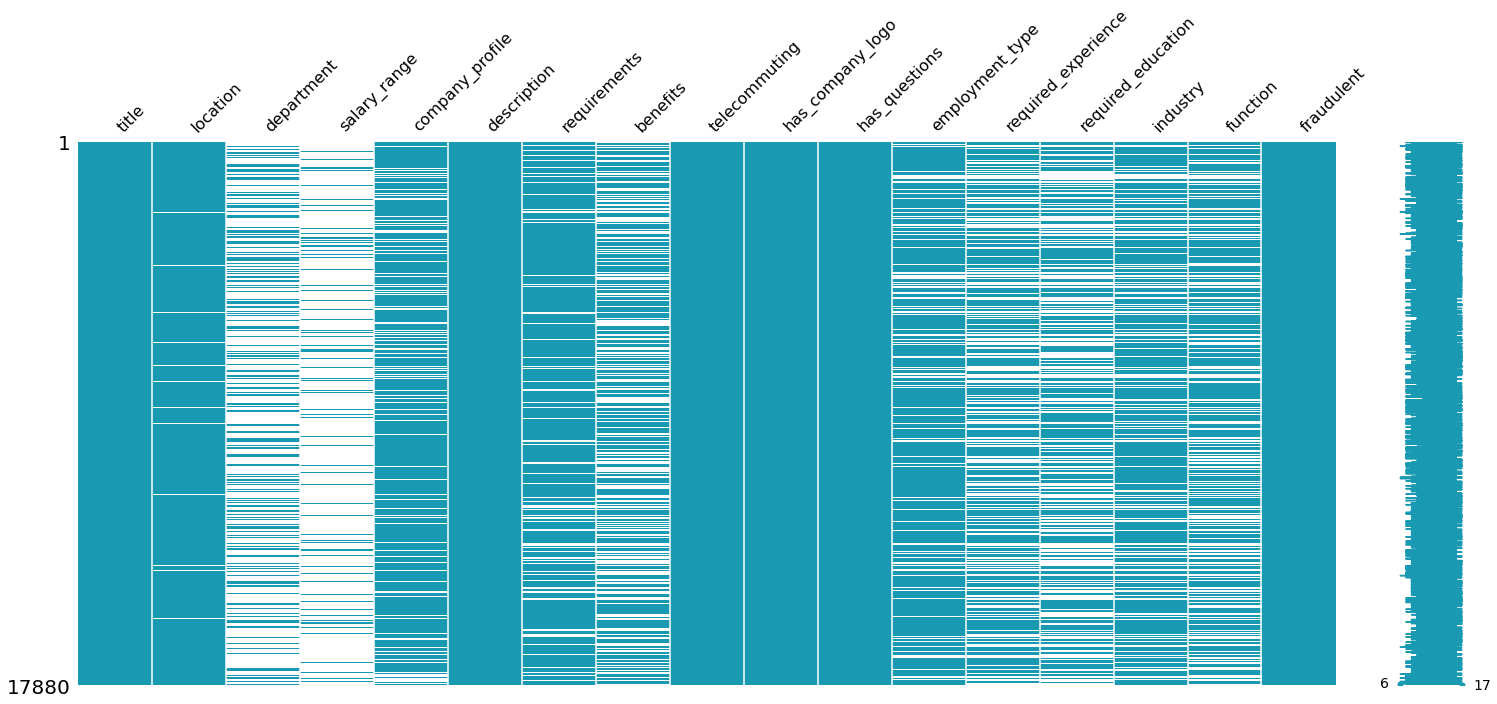

In [4]:
# checking missing data in our dataframe.
missingno.matrix(df,color=(0.1, 0.6, 0.7))

- oh wow lots of missing values

In [5]:
for items in df["industry"].value_counts().iteritems(): 
    print(items)

('Information Technology and Services', 1734)
('Computer Software', 1376)
('Internet', 1062)
('Marketing and Advertising', 828)
('Education Management', 822)
('Financial Services', 779)
('Hospital & Health Care', 497)
('Consumer Services', 358)
('Telecommunications', 342)
('Oil & Energy', 287)
('Retail', 223)
('Real Estate', 175)
('Accounting', 159)
('Construction', 158)
('E-Learning', 139)
('Management Consulting', 130)
('Design', 129)
('Health, Wellness and Fitness', 127)
('Staffing and Recruiting', 127)
('Insurance', 123)
('Automotive', 120)
('Logistics and Supply Chain', 112)
('Human Resources', 108)
('Online Media', 101)
('Apparel & Fashion', 97)
('Legal Services', 97)
('Facilities Services', 94)
('Hospitality', 88)
('Computer Games', 86)
('Banking', 84)
('Building Materials', 78)
('Nonprofit Organization Management', 76)
('Leisure, Travel & Tourism', 76)
('Entertainment', 74)
('Electrical/Electronic Manufacturing', 73)
('Food & Beverages', 72)
('Cosmetics', 65)
('Airlines/Aviatio

### Target
- Fraudulent

In [6]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [7]:
import matplotlib.colors as mcolors


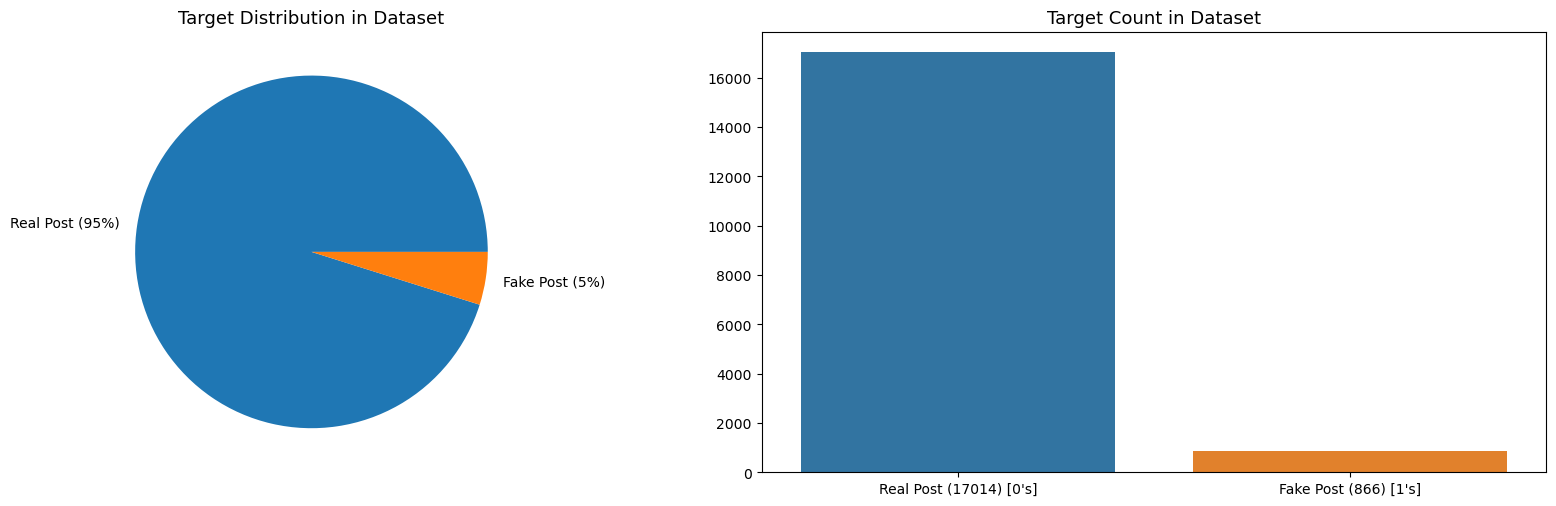

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100,)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fraudulent Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(temp.index, temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fraudulent Post (866) [1's]"])

axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

- First Row

In [9]:
#
df['has_benefit'] = pd.notnull(df["benefits"])
df['has_requirements'] = pd.notnull(df["requirements"])
df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements
job_id,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True


## Data Prep

In [10]:
df.location.isna().sum()

346

In [11]:
# Location
df['location'] = df['location'].fillna(' ')
df['location'] = df['location'].apply(lambda x: x[3:6] )
df['location'] = df['location'].replace(' , ','unknown' )

In [12]:
df['location'].value_counts()

unknown    2140
 CA        2062
 NY        1285
 LN         992
 TX         975
           ... 
 FI           1
 52           1
 PT           1
 05           1
 61           1
Name: location, Length: 251, dtype: int64

- Oh well, prob not even important 

In [13]:
df.company_profile[5]

'SpotSource Solutions LLC is a Global Human Capital Management Consulting firm headquartered in Miami, Florida. Founded in January 2012, SpotSource has created a fusion of innovative service offerings to meet the increasing demand of today’s economy. We specialize in Talent Acquisition, Staffing, and Executive Search Services across various functions and in specific industries. Global Talent Transfusion (GTT) services utilize best in practice qualification standards to deliver talent in temporary, temporary-to-hire, and permanent basis. Health Career Transition (HCT) is a subsidiary of Global Talent Transfusion and offers placement services specifically in the growing Healthcare arena. SpotSource Executive Search (SES) Consultants are special breed talent evangelists that understand how to advise and streamline the human resources process in the direction your organization requires for long term sustainability and success.\xa0Succession Planning. Leadership Development Programs. Compen

### Dealing with missing values from requirements and benefits

In [14]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_benefit', 'has_requirements'],
      dtype='object')

In [16]:
# Fill nulls with 'no benefit listed'
df['benefits'] = df['benefits'].fillna('no benefit listed')

# Fill nulls with 'no requirement listed'
df['requirements'] = df['requirements'].fillna('no requirement listed')

# Fill nulls with 'no description listed'
df['description'] = df['description'].fillna('unknown')

# Fill nulls with 'no required_experience listed'
df['required_experience'] = df['required_experience'].fillna('unknown')

# Fill nulls with 'no company_profile listed'
df['company_profile' ]= df['company_profile'].fillna('unknown')

# Fill nulls with 'no companylogo'
df.has_company_logo.replace({0:"nocompanylogo",1:'hascompanylogo'},inplace=True)



## Categoricals

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


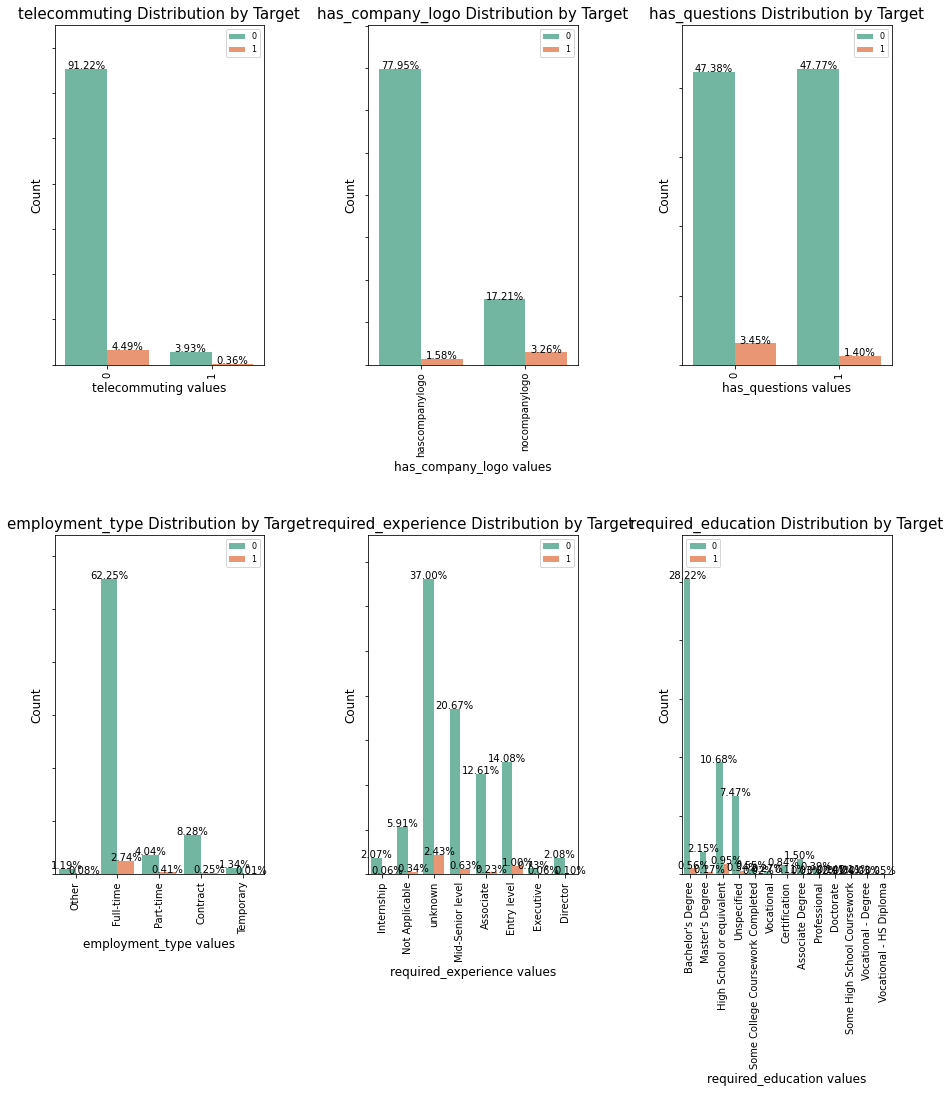

In [17]:
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating categorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show();

In [18]:
df['has_company_logo' ].isna().sum()

0

In [19]:
df['benefits']

job_id
1                                        no benefit listed
2        What you will get from usThrough being part of...
3                                        no benefit listed
4        Our culture is anything but corporate—we have ...
5                                    Full Benefits Offered
                               ...                        
17876    What can you expect from us?We have an open cu...
17877    Health &amp; WellnessMedical planPrescription ...
17878                                    no benefit listed
17879    Competitive salary (compensation will be based...
17880                                    no benefit listed
Name: benefits, Length: 17880, dtype: object

In [20]:
df.company_profile.isna().sum()

0

 ### Combining our text data in a single column to start the cleaning  process

In [21]:
df['has_company_logo' ]

job_id
1        hascompanylogo
2        hascompanylogo
3        hascompanylogo
4        hascompanylogo
5        hascompanylogo
              ...      
17876    hascompanylogo
17877    hascompanylogo
17878     nocompanylogo
17879     nocompanylogo
17880    hascompanylogo
Name: has_company_logo, Length: 17880, dtype: object

In [22]:
# 
df['text'] = '  '+ df['title'] +'  '+ df['description'] +'  '+ df['requirements']+'  '+ \
                   df['benefits']+'  '+ df['required_experience'] + '  ' + df['has_company_logo' ] + '  ' + \
                   df['company_profile' ] + '  '
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements,text
job_id,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,NY,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,no benefit listed,0,hascompanylogo,0,Other,Internship,NaN,NaN,Marketing,0,False,True,"Marketing Intern Food52, a fast-growing, Ja..."
2,Customer Service - Cloud Video Production,unknown,Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,hascompanylogo,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,True,True,Customer Service - Cloud Video Production O...


In [23]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = df[df.fraudulent==1].text
actual_jobs_text = df[df.fraudulent==0].text

In [24]:
actual_jobs_text

job_id
1          Marketing Intern  Food52, a fast-growing, Ja...
2          Customer Service - Cloud Video Production  O...
3          Commissioning Machinery Assistant (CMA)  Our...
4          Account Executive - Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE: Itemization ...
                               ...                        
17876      Account Director - Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer - Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we?Vend ...
Name: text, Length: 17014, dtype: object

In [25]:
fraud_jobs_text

job_id
99         IC&E Technician  IC&amp;E Technician | Baker...
145        Forward Cap.  The group has raised a fund fo...
174        Technician Instrument & Controls   Technicia...
181        Sales Executive  Sales Executive  Sales Exec...
216        IC&E Technician Mt Poso  IC&amp;E Technician...
                               ...                        
17828      Student Positions Part-Time and Full-Time.  ...
17829      Sales Associate  LEARN TO EARN AN EXECUTIVE ...
17830      Android Developer  inFullMobile Sp. z o.o. i...
17831      Payroll Clerk   JOB DESCRIPTIONWe are seekin...
17832      Furniture mover  earn $500 to $1000 a week a...
Name: text, Length: 866, dtype: object

In [26]:
actual_jobs_text.value_counts().sum()

17014

In [27]:
fraud_jobs_text.value_counts().sum()

866

# WordCloud

## Fraudulent Words!!!  X

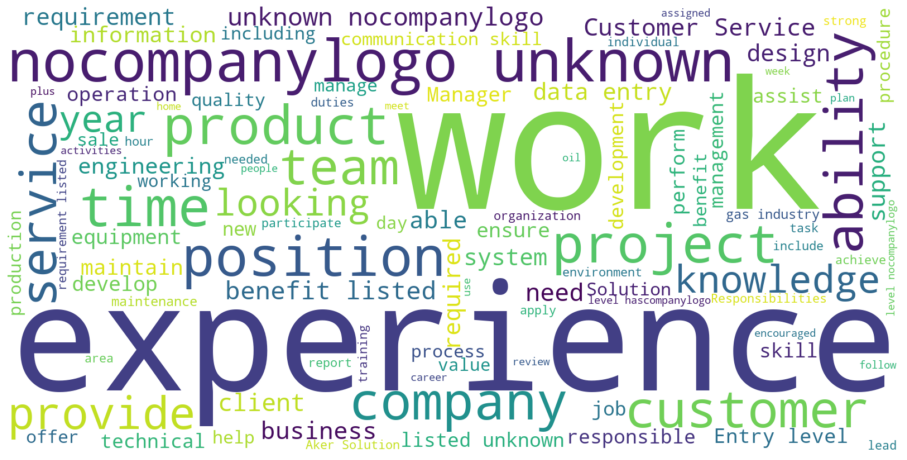

In [28]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`

## Not Fraudulent Words! lol ✓

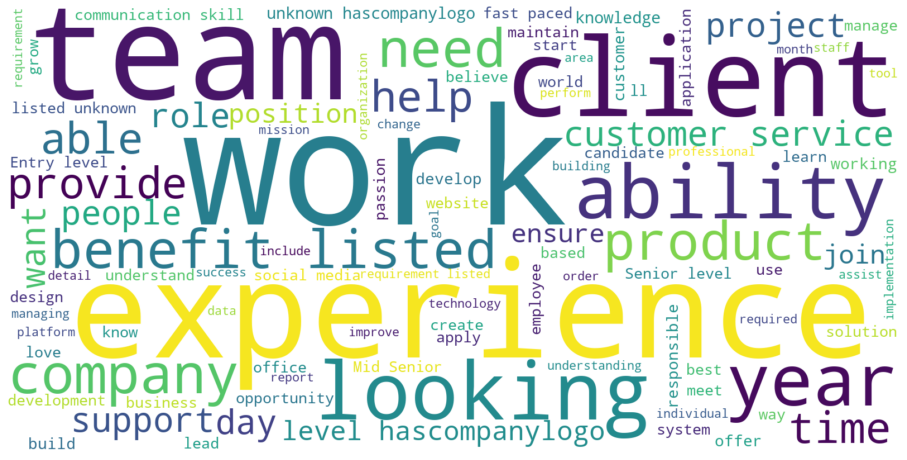

In [29]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

## Data Cleaning

In [30]:
# only need target and text
data = df[["fraudulent", "text"]]
data

,fraudulent,text
job_id,,
1,0,"Marketing Intern Food52, a fast-growing, Ja..."
2,0,Customer Service - Cloud Video Production O...
3,0,Commissioning Machinery Assistant (CMA) Our...
4,0,Account Executive - Washington DC THE COMPA...
5,0,Bill Review Manager JOB TITLE: Itemization ...
...,...,...
17876,0,Account Director - Distribution Just in ca...
17877,0,Payroll Accountant The Payroll Accountant w...
17878,0,Project Cost Control Staff Engineer - Cost C...


In [31]:
data.text.isna().sum()

0

Trying with Spacy

In [32]:
# Taken from: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/


In [33]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

## Remove punctionation and numbers, and turn lowercase

In [36]:
def remove_punctuations(text):
    for punctuation in punctuations:
        text = text.replace(punctuation, ' ')
    return text


In [37]:
# Apply to the DF series
data.text = data.text.apply(remove_punctuations)

In [38]:
data.text

job_id
1          Marketing Intern  Food52  a fast growing  Ja...
2          Customer Service   Cloud Video Production  O...
3          Commissioning Machinery Assistant  CMA   Our...
4          Account Executive   Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE  Itemization ...
                               ...                        
17876      Account Director   Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer   Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we Vend ...
Name: text, Length: 17880, dtype: object

In [40]:
#remove weird numbers
def remove_number(text):
    numbers_to_remove = ['1', '2', '3', '4','5', '6', '7', '8', '9', '0', "\xa0" ]
    clean_text = text
    for num in numbers_to_remove:
        clean_text = clean_text.replace(num, ' ')
    
    return clean_text

In [41]:
data.text = data.text.apply(remove_number)
data.text


job_id
1          Marketing Intern  Food    a fast growing  Ja...
2          Customer Service   Cloud Video Production  O...
3          Commissioning Machinery Assistant  CMA   Our...
4          Account Executive   Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE  Itemization ...
                               ...                        
17876      Account Director   Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer   Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we Vend ...
Name: text, Length: 17880, dtype: object

- All punctuations removed, next turn all lowercase


In [42]:
# All lowercase
data.text = data.text.str.lower()
# Adding State last to keep it Caps
data.text = data['text'] +'  '+ df['location']+'  '

In [43]:
data.text[108]

'  senior developer at a startup investment studio   forward partners invest in very early stage e commerce startups and help them to grow   we have an in house team of designers  marketers and product managers who work with the founders of these companies and guide them through their growth and development you might have heard of some of the companies we ve helped and invested in already   hailo  zopa  wool and the gang  thread  big health  stylect  makers academy   url  e  a   c      c       c eb   aedb   df b  a     ced       f       driftrock  top    snaptrip  loyalty bay and appear here we re looking for a skilled developer  who can make our entrepreneurs ideas a reality  you ll build prototypes  offer expert guidance and make suggestions for innovations all working in an agile fashion with the company founders and forward partners team   ideally  you ll comfortable making architectural choices and enjoy getting your hands dirty   you ll own every stage of coding  testing and depl

#### WordCloud Clean

In [44]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = data[data.fraudulent==1].text
actual_jobs_text = data[data.fraudulent==0].text

In [45]:
actual_jobs_text

job_id
1          marketing intern  food    a fast growing  ja...
2          customer service   cloud video production  o...
3          commissioning machinery assistant  cma   our...
4          account executive   washington dc  the compa...
5          bill review manager  job title  itemization ...
                               ...                        
17876      account director   distribution   just in ca...
17877      payroll accountant  the payroll accountant w...
17878      project cost control staff engineer   cost c...
17879      graphic designer  nemsia studios is looking ...
17880      web application developers  who are we vend ...
Name: text, Length: 17014, dtype: object

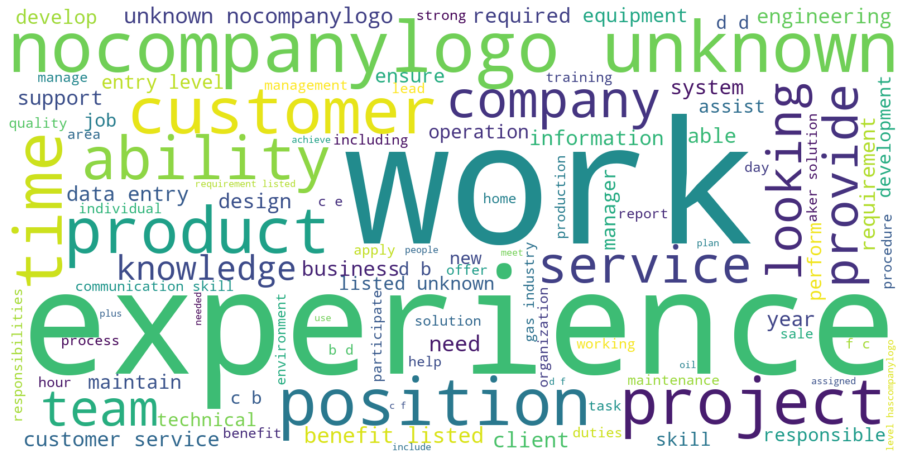

In [46]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

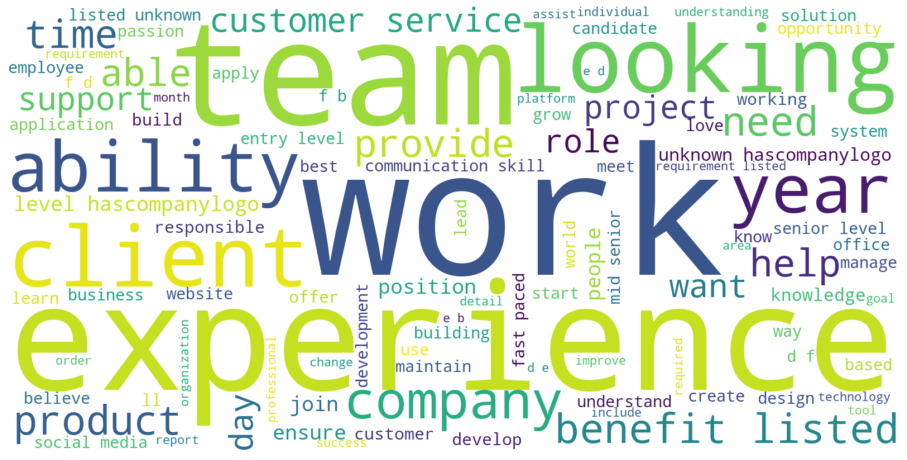

In [47]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

In [48]:
# Custom transformer 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [49]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = word_tokenize, ngram_range=(1,3),lowercase=True)


In [50]:
bow_vector

CountVectorizer(ngram_range=(1, 3),
                tokenizer=<function word_tokenize at 0x7fc95f43e430>)

![image](https://www.mcafeetaft.com/wp-content/uploads/scam-alert-graphic-feature-660x371.jpg)

# Modelling

In [51]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, 
                                                    test_size=0.3)

In [52]:
y_train.value_counts()

0    11914
1      602
Name: fraudulent, dtype: int64

In [53]:
# smote = SMOTE(random_state=42)

In [54]:
# X_smote, y_smote = smote.fit_sample(X_train, y_train)

In [55]:
X_train

job_id
4955       file clerk  professional civil process  pcp ...
17763      optician   sales  we are a long term well es...
5773       mobile app developer  android   ios   ref  p...
13889      experienced servers and bartenders  fine din...
7053       english teacher abroad  conversational   pla...
                               ...                        
3916       data warehouse manager   business intelligen...
11717      delivery services manager  as a delivery ser...
1262       freelance translators  m f  from swedish and...
13941      collections supervisor  to apply  please vis...
13932      medium duty driver  responsible for daily de...
Name: text, Length: 12516, dtype: object

In [56]:
#!python -m spacy download en_core_web_sm

In [57]:
from imblearn.under_sampling import RandomUnderSampler


In [58]:
clf = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', bow_vector),
                # ('under',RandomUnderSampler('majority',random_state=42)),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fc8eb102220>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fc95f43e430>)),
                ('classifier', LogisticRegression())])

In [59]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print("Logistic Regression Recall:", recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9856450410141685
Logistic Regression Recall: 0.7272727272727273


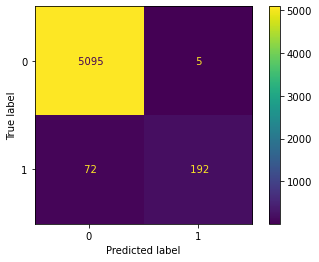

In [60]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')

## Oh boy XD XD XD

1. Random Forest

In [61]:
clf = RandomForestClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fc94bd64ac0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fc95f43e430>)),
                ('classifier', RandomForestClassifier())])

In [62]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9841536167039523
Random Forest Recall: 0.6818181818181818


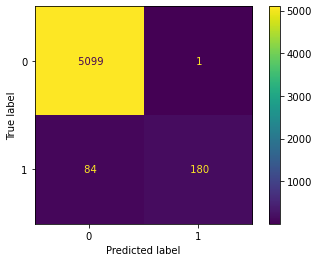

In [63]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')

XGBoost Classifier

In [64]:
clf = XGBClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fc947c23af0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fc95f43e430>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
            

In [65]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, predicted))
print("XGBoost Recall:", recall_score(y_test, predicted))

XGBoost Accuracy: 0.9862043251304996
XGBoost Recall: 0.7613636363636364


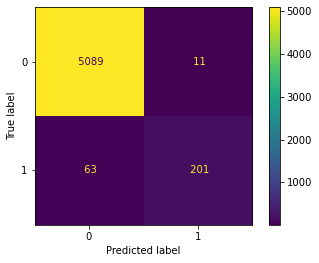

In [66]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                     # cmap='Reds', 
                      values_format=' ')


# Try deal with imbalance

## Oversampling

In [67]:
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, cross_validate , GridSearchCV, cross_val_predict


# TfidfVectorizer

In [68]:
imb_log_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])

imb_log_results = cross_validate(imb_log_model,X_train,y_train,return_train_score=True)


In [69]:
imb_log_preds = cross_val_predict(imb_log_model,X_train,y_train)


In [70]:
# fitting the model
imb_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [71]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9601043997017151
Recall: 0.8522727272727273


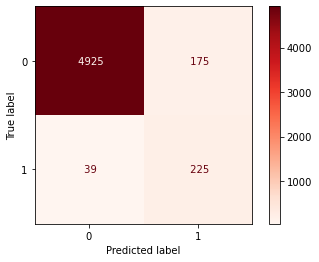

In [72]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

# bow_vector

In [73]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', bow_vector),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])

# imb_log_results = cross_validate(imb_log_model,X_train,y_train,return_train_score=True)



In [74]:
# imb_log_preds = cross_val_predict(imb_log_model,X_train,y_train)


In [75]:
# fitting the model
imb_log_model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fc95f43e430>)),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [76]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9852721849366145
Recall: 0.7992424242424242


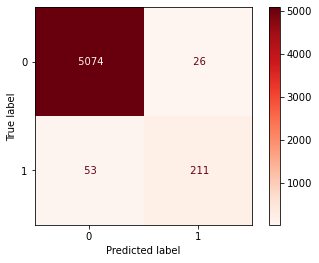

In [77]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

## CountVectorizer and over

In [78]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', CountVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])
# fitting the model
imb_log_model.fit(X_train,y_train)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [79]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9755779269202088
Recall: 0.8181818181818182


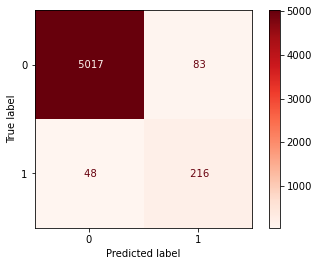

In [80]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

- CountVectorizer and over looks good. We've got a winner

## Undersampling 

### TfidfVectorizer

In [81]:
under_log_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LR',LogisticRegression())])

# fitting the model
under_log_model.fit(X_train,y_train)


Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('LR', LogisticRegression())])

In [82]:
# Predicting with a test
predicted = under_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9326994780014914
Recall: 0.8712121212121212


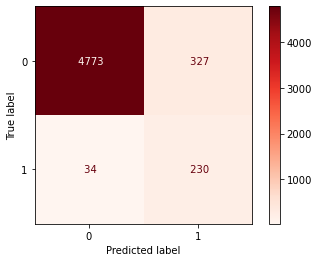

In [83]:
plot_confusion_matrix(under_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

- ouch that was pretty bad

## CountVectorizer

In [84]:
under_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LR',LogisticRegression())])

# fitting the modela
under_log_model.fit(X_train,y_train)



Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('LR', LogisticRegression())])

In [85]:
# Predicting with a test
predicted = under_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.8905667412378822
Recall: 0.946969696969697


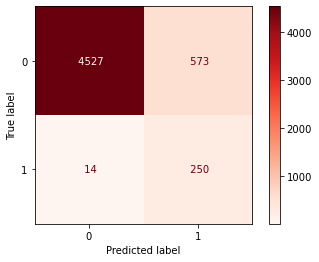

In [86]:
plot_confusion_matrix(under_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

# Testing Indeed Dataset !!

## CountVectorizer and over

In [78]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', CountVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])
# fitting the model
imb_log_model.fit(X_train,y_train)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [79]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9755779269202088
Recall: 0.8181818181818182


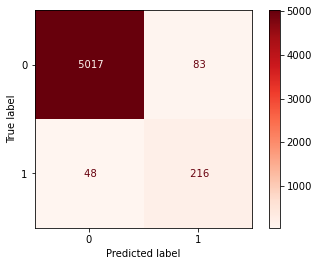

In [80]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

- CountVectorizer and over looks good. We've got a winner

# Lime

In [87]:
#!pip install lime

In [88]:
#from lime import lime_tabular

In [89]:
#df.head(1)

In [90]:
# Lime = df[["fraudulent","has_benefit","has_requirements"]]
# Lime.head(2)

In [91]:
# X = Lime.drop(['fraudulent'], axis=1) # Features matrix
# y = Lime['fraudulent']                # Target variable


In [92]:
# # Train Test Split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.02, random_state=42
# )

In [93]:
# RF = RandomForestClassifier(random_state=42)
# output = RF.fit(X_train, y_train)
# RF.score(X_test, y_test)

In [94]:
# # we can calculate predictions for confusion matrix
# test_preds= RF.predict(X_test)
# cm=confusion_matrix(y_test, test_preds)

In [95]:
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax=ax, linewidths=1, cbar=False)
# ax.set_title('Confusion Matrix')
# ax.set_xlabel('Predictions', fontsize = 15)
# ax.set_ylabel('Actuals', fontsize = 15)
# ax.xaxis.set_ticklabels(['No Fraud', 'Fraud'])
# ax.yaxis.set_ticklabels(['No Fraud', 'Fraud'], rotation = 0, fontsize = 10);

In [96]:
# RF = RandomForestClassifier(random_state=42)
# output = RF.fit(X_train, y_train)
# RF.score(X_test, y_test)

In [97]:
# explainer = lime_tabular.LimeTabularExplainer(
#  training_data=np.array(X_train),
#  feature_names=X_train,
#  class_names=[0, 1],
#  mode='classification'
# )

In [98]:
# i=15 # choosing one patient from X_test
# exp = explainer.explain_instance(
#  data_row = X_test.iloc[i], 
#  predict_fn=RF.predict_proba
# )
# exp.show_in_notebook(show_table=True)

In [99]:
# # only need target and text
# Lime = df[["fraudulent", "description","requirements","benefits"]]
# Lime

In [100]:
# # Apply to the DF series
# Lime.description = Lime.description.apply(remove_punctuations)
# Lime.benefits = Lime.benefits.apply(remove_punctuations)
# Lime.requirements = Lime.requirements.apply(remove_punctuations)


In [101]:
# Lime.description = Lime.description.str.lower()
# Lime.benefits = Lime.benefits.str.lower()
# Lime.requirements = Lime.requirements.str.lower()
